# Diffusion
OK, this is the big step up to diffusion. We are going to need to rethink our approach to produce coherence from noise.

In [35]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import numpy as np

import matplotlib.pyplot as plt

import math

from tqdm import tqdm

In [5]:
import sys
sys.path.append('..')
from diffusion_models import utils

DATA_PATH = '../data/'
train_loader, test_loader = utils.get_mnist(32, DATA_PATH)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Variance schedule
First implement our beta scheduler. It is a fine art choosing the correct schedule.

In [6]:
T = 150 # number of time steps
start = 0.0001 # starting variance
end = 0.03 # final variance

beta = torch.linspace(start, end, T).to(device)

In [7]:
sample_image, target, label = next(iter(train_loader))
sample_image = sample_image[0]

To generate noise at a specific variance, we can use the following formula:

$$
x_t = \sqrt{1 - \beta_t}x_{t-1} + \sqrt{\beta_t}\epsilon_t
$$

But of course we have to do this iteratively

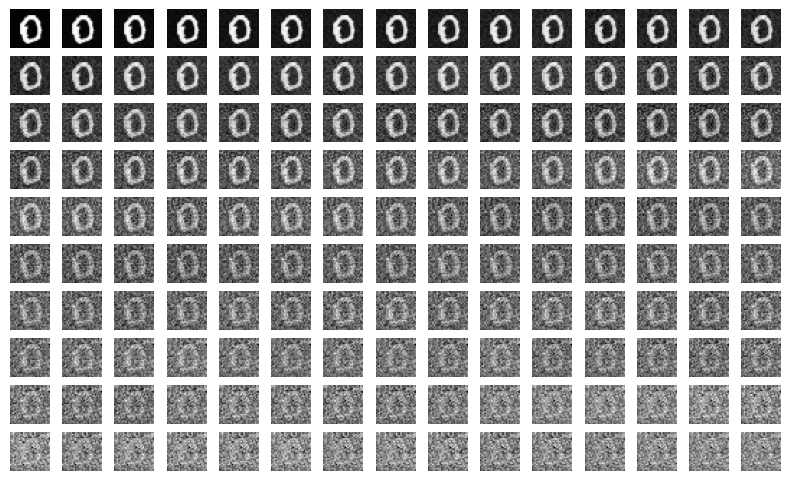

In [16]:
plt.figure(figsize=(10,6))
x_0 = sample_image[0]
x_t = x_0

for t in range(T):
    noise = torch.randn_like(x_t)
    x_t = torch.sqrt(1 - beta[t]) * x_t + torch.sqrt(beta[t]) * noise
    img = torch.squeeze(x_t).numpy()
    plt.subplot(10, 15, t+1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
plt.show()
    

Now we define a new variable $\alpha$ the cumulative product, $\bar{\alpha}$, and to make things easier, we also need to define $\sqrt{\bar{\alpha}}$ and $\sqrt{1-\bar{\alpha}}$

In [17]:
alpha = 1. - beta
alpha_bar = torch.cumprod(alpha, dim=0)
sqrt_alpha_bar = torch.sqrt(alpha_bar)
sqrt_one_minus_alpha_bar = torch.sqrt(1 - alpha_bar)

## Forward diffusion
If you remember, the forward diffusion process can be written as:

$$
x_t = \sqrt{\bar{\alpha}_t}x_0 + \sqrt{1-\bar{\alpha}_t}\epsilon
$$

where $\epsilon \sim N(0, 1)$.

In [37]:
def q(x_0, t):
    t = t.int()
    noise = torch.randn_like(x_0)
    sqrt_a_bar_t = sqrt_alpha_bar[t, None, None, None]
    sqrt_one_minus_a_bar_t = sqrt_one_minus_alpha_bar[t, None, None, None]

    x_t = sqrt_a_bar_t * x_0 + sqrt_one_minus_a_bar_t * noise
    return x_t, noise

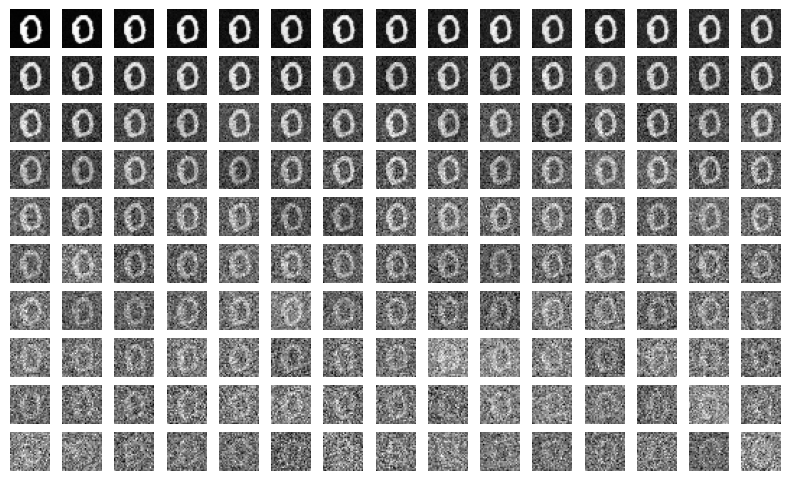

In [20]:
plt.figure(figsize=(10,6))
x_0 = sample_image[0]

for t in range(T):
    x_t = q(x_0, torch.tensor(t))[0]
    img = torch.squeeze(x_t).numpy()
    plt.subplot(10, 15, t+1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
plt.show()

Great so it's basically the same

# Loss function and conditional U-Net
We define a loss function that finds the MSE between the noise predicted by the model, and the total noise (i.e. pure noise).

In [38]:
def loss_function(model, x_0, t, label):
    x_noisy, noise = q(x_0, t)
    noise_pred = model(x_noisy, t, label)
    return F.mse_loss(noise, noise_pred)

We also add a way for the model to take in the time, and the context, in the same way as before.

In [39]:
class SinusoidBlock(nn.Module):
    def __init__(self, embedding_dim):
        super().__init__()
        self.embedding_dim = embedding_dim

    def forward(self, time):
        device = time.device
        half = self.embedding_dim // 2
        embeddings = math.log(10000) / (half - 1)
        embeddings = torch.exp(torch.arange(half, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings


class TimeBlock(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.in_features = in_features
        layers = [
            nn.Linear(in_features=in_features, out_features=out_features),
            nn.ReLU(),
            nn.Linear(in_features=out_features, out_features=out_features),
            nn.Unflatten(dim=1, unflattened_size=(out_features, 1, 1)),

        ]
        self.model = nn.Sequential(*layers)

    def forward(self, input):
        input = input.view(-1, self.in_features)
        return self.model(input)


class ContextBlock(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.in_features = in_features
        layers = [
            nn.Linear(in_features=in_features, out_features=out_features),
            nn.ReLU(),
            nn.Linear(in_features=out_features, out_features=out_features),
            nn.Unflatten(dim=1, unflattened_size=(out_features, 1, 1))
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, input):
        input = input.view(-1, self.in_features)
        return self.model(input)


class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(num_features=out_channels)
        self.pool1 = nn.MaxPool2d(kernel_size=2)

    def forward(self, x):
        x1 = F.relu(self.bn1(self.conv1(x)))
        x2 = self.pool1(x1)
        return x1, x2
    

class UpBlock(nn.Module):
    def __init__(self, in_channels, residual_channels, out_channels):
        super().__init__()

        self.upconv1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv1 = nn.Conv2d(in_channels=in_channels + residual_channels, out_channels=out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(num_features=out_channels)
        # self.conv2 = nn.Conv2d(in_channels=8, out_channels=out_channels//2, kernel_size=3, padding=1)


    def forward(self, x1, residual):
        x3 = self.upconv1(x1)
        x3 = torch.cat([x3, residual], dim=1)
        x4 = F.relu(self.bn1(self.conv1(x3)))
        return x4
            

class UNetSmol(nn.Module):
    def __init__(self, input_channels=1, output_channels=1):
        super().__init__()

        # Encoder
        self.down1 = DownBlock(in_channels=input_channels, out_channels=16)
        self.down2 = DownBlock(in_channels=16, out_channels=32)

        # Bottleneck
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(num_features=64)

        # Decoder
        self.up1 = UpBlock(in_channels=64, residual_channels=32, out_channels=32)
        self.up2 = UpBlock(in_channels=32, residual_channels=16, out_channels=16)
        self.conv6 = nn.Conv2d(in_channels=16, out_channels=output_channels, kernel_size=1)

        # combined with bottlenect output
        self.time_embedder = SinusoidBlock(embedding_dim=32)
        self.time_embedder_1 = TimeBlock(in_features=32, out_features=64)
        self.time_embedder_2 = TimeBlock(in_features=32, out_features=32)
        self.label_encoder_1 = ContextBlock(in_features=10, out_features=64)
        self.label_encoder_2 = ContextBlock(in_features=10, out_features=32)


    def forward(self, x, t, labels=None):
        # Down
        x1, x2 = self.down1(x)
        x3, x4 = self.down2(x2)

        # Bottleneck
        x5 = F.relu(self.bn3(self.conv3(x4)))

        # Up
        t = self.time_embedder(t)
        time_embedding_1 = self.time_embedder_1(t)

        label_embedding_1 = self.label_encoder_1(labels)
        x5 = label_embedding_1 * x5 + time_embedding_1
        
        x6 = self.up1(x5, x3)

        time_embedding_2 = self.time_embedder_2(t)
        label_embedding_2 = self.label_encoder_2(labels)
        x6 = label_embedding_2 * x6 + time_embedding_2

        x7 = self.up2(x6, x1)
        

        x8 = self.conv6(x7)
        return x8

In [40]:
model = UNetSmol(1, 1)
optimizer = optim.AdamW(model.parameters(), lr=0.001)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [41]:
sample_image, target, label = next(iter(train_loader))
loss = loss_function(model, sample_image, torch.tensor(0), label)

In [44]:
num_epochs = 10

losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for sample_image, target, label in tqdm(train_loader):
        sample_image = sample_image.to(device)
        target = target.to(device)
        label = label.to(device)
        optimizer.zero_grad()
        t = torch.randint(0, T, (32,), device=device)
        # t = t.float()
        loss = loss_function(model, sample_image, t, label)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        losses.append(loss.item())

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')


  0%|          | 0/1875 [00:00<?, ?it/s]

In [55]:
sqrt_a_inv = torch.sqrt(1 / alpha)
pred_noise_coeff = (1 - alpha) / torch.sqrt(1 - alpha_bar)

In [56]:
@torch.no_grad()
def reverse_q(x_t, t, epsilon_t):
    t = torch.squeeze(t[0].int())
    pred_noise_coeff_t = pred_noise_coeff[t]
    sqrt_a_inv_t = sqrt_a_inv[t]
    u_t = sqrt_a_inv_t * (x_t - pred_noise_coeff_t * epsilon_t)
    if t == 0:
        return u_t
    else:
        beta_t = beta[t-1]
        new_noise = torch.randn_like(x_t)
        return u_t + torch.sqrt(beta_t) * new_noise

In [48]:
# save model
torch.save(model.state_dict(), 'model_bigger.pth')

In [57]:
@torch.no_grad()
def sample_images(number=1):

    # generate random noise
    x_t = torch.randn(1, 1, 28, 28, device=device)
    label = torch.zeros(1, 10, device=device)
    label[0, number] = 1
    
    x_ts = []
    for i in range(0, T)[::-1]:
        print(i)
        t = torch.full((1,), i, device=device)
        t = t.float()
        e_t = model(x_t, t, label)
        x_t = reverse_q(x_t, t, e_t)
        x_ts.append(x_t)

    return x_ts

149
148
147
146
145
144
143
142
141
140
139
138
137
136
135
134
133
132
131
130
129
128
127
126
125
124
123
122
121
120
119
118
117
116
115
114
113
112
111
110
109
108
107
106
105
104
103
102
101
100
99
98
97
96
95
94
93
92
91
90
89
88
87
86
85
84
83
82
81
80
79
78
77
76
75
74
73
72
71
70
69
68
67
66
65
64
63
62
61
60
59
58
57
56
55
54
53
52
51
50
49
48
47
46
45
44
43
42
41
40
39
38
37
36
35
34
33
32
31
30
29
28
27
26
25
24
23
22
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1
0
149
148
147
146
145
144
143
142
141
140
139
138
137
136
135
134
133
132
131
130
129
128
127
126
125
124
123
122
121
120
119
118
117
116
115
114
113
112
111
110
109
108
107
106
105
104
103
102
101
100
99
98
97
96
95
94
93
92
91
90
89
88
87
86
85
84
83
82
81
80
79
78
77
76
75
74
73
72
71
70
69
68
67
66
65
64
63
62
61
60
59
58
57
56
55
54
53
52
51
50
49
48
47
46
45
44
43
42
41
40
39
38
37
36
35
34
33
32
31
30
29
28
27
26
25
24
23
22
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1
0
149
148
147
146
145


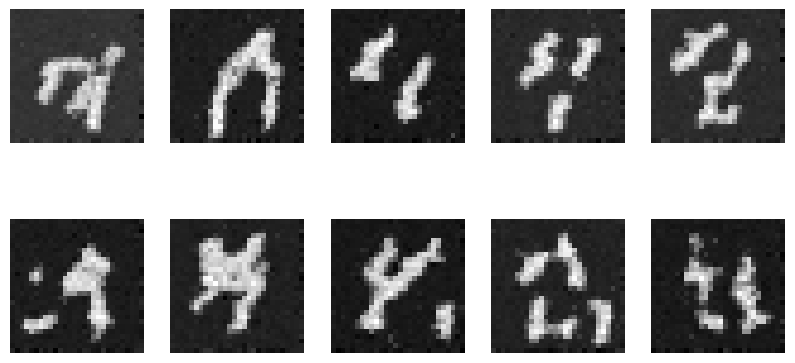

In [58]:
plt.figure(figsize=(10, 5))
model.eval()
for i in range(10):
    x_t = sample_images(number=1)[-1]
    img = torch.squeeze(input=x_t).cpu()
    ax = plt.subplot(2, 5, i + 1)
    ax.axis('off')
    plt.imshow(img, cmap='gray')


149
148
147
146
145
144
143
142
141
140
139
138
137
136
135
134
133
132
131
130
129
128
127
126
125
124
123
122
121
120
119
118
117
116
115
114
113
112
111
110
109
108
107
106
105
104
103
102
101
100
99
98
97
96
95
94
93
92
91
90
89
88
87
86
85
84
83
82
81
80
79
78
77
76
75
74
73
72
71
70
69
68
67
66
65
64
63
62
61
60
59
58
57
56
55
54
53
52
51
50
49
48
47
46
45
44
43
42
41
40
39
38
37
36
35
34
33
32
31
30
29
28
27
26
25
24
23
22
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1
0


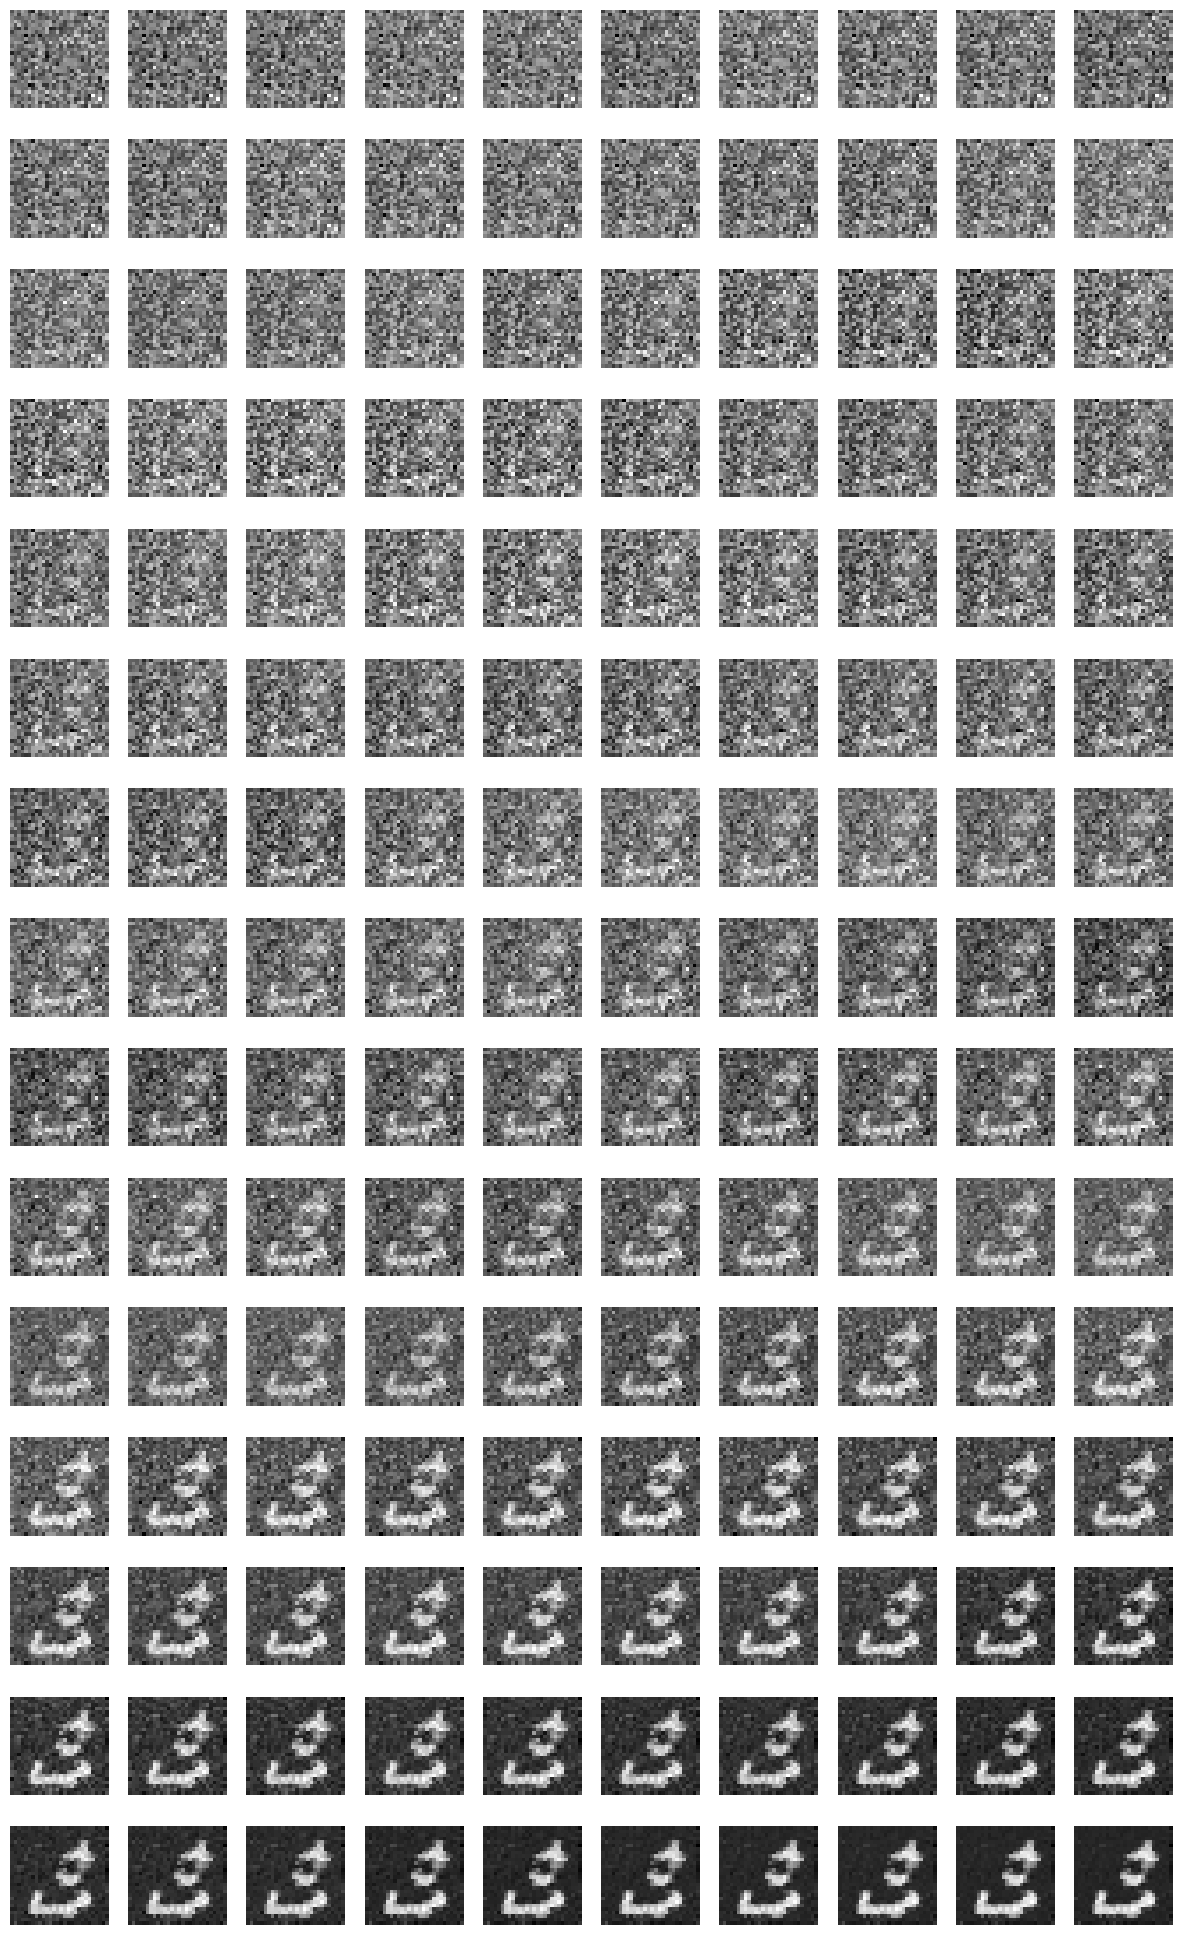

In [59]:
plt.figure(figsize=(15, 25))
x_ts = sample_images(5)

for t, x_t in enumerate(x_ts):
    img = x_t.cpu().squeeze().numpy()
    
    ax = plt.subplot(15, 10, t + 1)
    ax.axis('off')
    plt.imshow(img, cmap='gray')

In [62]:
x_ts[0].cpu().squeeze().numpy().shape

(28, 28)

In [19]:
sample = sample_image[0].unsqueeze(0)

In [34]:
# now pass a single instance of pure noise through the network once


# add a small amount of noise to the image
noise = torch.randn_like(sample) * 0.001
x_t = sample + noise

label = torch.zeros(1, 10, device=device)
label[0, 5] = 1

x_ts = []
result = model(x_t, torch.tensor([149.], device=device), label)

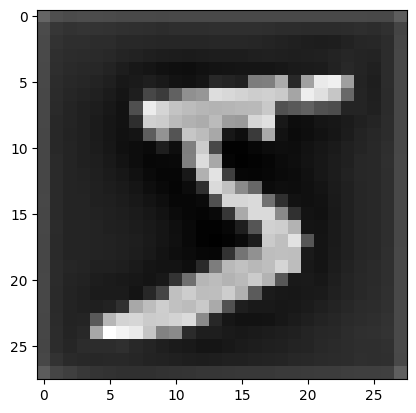

In [35]:
# plot
plt.imshow(result.squeeze().detach().numpy(), cmap='gray')

In [62]:
print(f'Alpha: {alpha}')
print(f'Alpha Bar: {alpha_bar}')
print(f'Sqrt Alpha Bar: {sqrt_alpha_bar}')
print(f'Sqrt One Minus Alpha Bar: {sqrt_one_minus_alpha_bar}')
print(f'Noise Coefficient: {pred_noise_coeff}')
print(f'Sqrt Alpha Inv: {sqrt_a_inv}')

Alpha: tensor([0.9999, 0.9997, 0.9995, 0.9993, 0.9991, 0.9989, 0.9987, 0.9985, 0.9983,
        0.9981, 0.9979, 0.9977, 0.9975, 0.9973, 0.9971, 0.9969, 0.9967, 0.9965,
        0.9963, 0.9961, 0.9959, 0.9957, 0.9955, 0.9953, 0.9951, 0.9949, 0.9947,
        0.9945, 0.9943, 0.9941, 0.9939, 0.9937, 0.9935, 0.9933, 0.9931, 0.9929,
        0.9927, 0.9925, 0.9923, 0.9921, 0.9919, 0.9917, 0.9915, 0.9913, 0.9911,
        0.9909, 0.9907, 0.9905, 0.9903, 0.9901, 0.9899, 0.9897, 0.9895, 0.9893,
        0.9891, 0.9889, 0.9887, 0.9885, 0.9883, 0.9881, 0.9879, 0.9877, 0.9875,
        0.9873, 0.9871, 0.9869, 0.9867, 0.9865, 0.9863, 0.9861, 0.9859, 0.9857,
        0.9855, 0.9853, 0.9851, 0.9848, 0.9846, 0.9844, 0.9842, 0.9840, 0.9838,
        0.9836, 0.9834, 0.9832, 0.9830, 0.9828, 0.9826, 0.9824, 0.9822, 0.9820,
        0.9818, 0.9816, 0.9814, 0.9812, 0.9810, 0.9808, 0.9806, 0.9804, 0.9802,
        0.9800, 0.9798, 0.9796, 0.9794, 0.9792, 0.9790, 0.9788, 0.9786, 0.9784,
        0.9782, 0.9780, 0.9778, 0